In [1]:
from typing import Dict

import pyro
import torch
from pyro.infer.autoguide import AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointIntervention,
    DynamicIntervention,
    SimulatorEventLoop,
    simulate,
    ODEDynamics,
)

from causal_pyro.dynamical.handlers import NonInterruptingPointObservationArray

from causal_pyro.dynamical.ops import State, Trajectory

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

In [2]:
class TrajectoryObservation(pyro.poutine.messenger.Messenger):
    def __init__(
        self,
        data: Dict[float, Dict[str, torch.Tensor]],
        eps: float = 1e-6,
    ):
        times = torch.tensor([t for t, _ in data.items()])
        data_obs_dicts = [s for _, s in data.items()]
        # data_obs_dicts is a list of dictionaries, each of which contains the observations at a single time point
        #  these need to be concatenated into a single array valued dictionary.
        data_obs = dict()
        for key in data_obs_dicts[0].keys():
            data_obs[key] = torch.stack([d[key] for d in data_obs_dicts])

        self.nipoa = NonInterruptingPointObservationArray(times, data_obs, eps=eps)

    def __enter__(self):
        self.nipoa.__enter__()

    def __exit__(self, *args, **kwargs):
        self.nipoa.__exit__(*args, **kwargs)

## Define our SIR model

In [3]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma, name=None):
        super().__init__()
        self.beta = beta
        self.gamma = gamma
        self.name = name

        if name is not None:
            self.postfix = f"_{name}"
        else:
            self.postfix = ""

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        # We don't observe the number of susceptible individuals directly, and instead can only infer it from the
        #  number of test kits that are sold (which is a noisy function of the number of susceptible individuals).
        
        test_kit_sales = torch.relu(pyro.sample(f"test_kit_sales{self.postfix}", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample(f"I_obs{self.postfix}", dist.Poisson(X.I))  # noisy number of infected actually observed
        R_obs = pyro.sample(f"R_obs{self.postfix}", dist.Poisson(X.R))  # noisy number of recovered actually observed

        return {
            f"test_kit_sales{self.postfix}": test_kit_sales,
            f"I_obs{self.postfix}": I_obs,
            f"R_obs{self.postfix}": R_obs,
        }

# Generate synthetic data from the SIR model

In [4]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
time_period = torch.linspace(0, 3, steps=21)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true = torch.tensor(0.5)
sir_true = SimpleSIRDynamics(beta_true, gamma_true)
sir_true_traj = simulate(sir_true, init_state, time_period)

### Simulate the latent trajectories of the ODE model

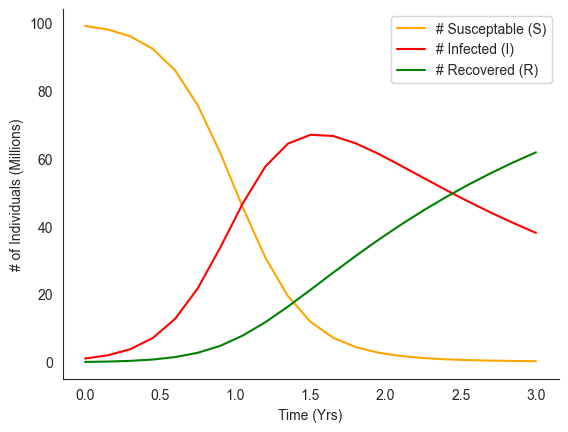

In [5]:
sns.lineplot(
    x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color="orange"
)
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color="red")
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color="green")
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Add noise to state trajectories to generate observations
 

In [6]:
obs_time_period = torch.arange(
    1 / 52, 1.01, 1 / 52
)  # collect data every week for the past 6mo
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir_true, init_state, obs_time_period)
sir_data = dict()
for time_ix in range(N_obs):
    sir_data[obs_time_period[time_ix].item()] = sir_true.observation(
        sir_obs_traj[time_ix]
    )

In [7]:
test_kit_sales = torch.stack(
    [sir_data[time.item()]["test_kit_sales"] for time in obs_time_period]
)
I_obs = torch.stack([sir_data[time.item()]["I_obs"] for time in obs_time_period])
R_obs = torch.stack([sir_data[time.item()]["R_obs"] for time in obs_time_period])

Text(0, 0.5, 'Observed # Recovered (Millions)')

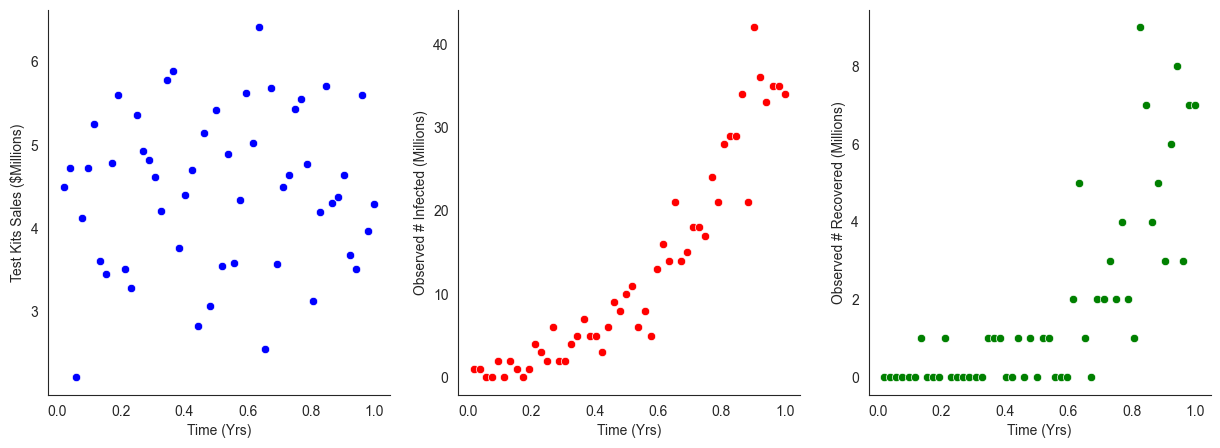

In [8]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.scatterplot(x=obs_time_period, y=test_kit_sales, color="blue", ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.scatterplot(x=obs_time_period, y=I_obs, color="red", ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.scatterplot(x=obs_time_period, y=R_obs, color="green", ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

## Extend our model to include uncertainty over model parameters

In [9]:
# We place uniform priors on the beta and gamma parameters defining the SIR model
def bayesian_sir(base_model=SimpleSIRDynamics):
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(init_state, tspan, base_model=SimpleSIRDynamics) -> Trajectory:
    sir = bayesian_sir(base_model)
    solution = simulate(sir, init_state, tspan)
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, getattr(solution, k)) for k in solution.keys]
    return solution


def conditioned_sir(data, init_state, tspan, base_model=SimpleSIRDynamics) -> None:
    sir = bayesian_sir(base_model)
    with SimulatorEventLoop():
        with TrajectoryObservation(data):
            simulate(sir, init_state, tspan)

# Perform Inference!

In [10]:
# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)


def run_svi_inference(
    conditioned_model, n_steps=100, verbose=True, **conditioned_model_kwargs
):
    guide = AutoMultivariateNormal(conditioned_model)
    adam = pyro.optim.Adam({"lr": 0.03})
    svi = SVI(conditioned_model, guide, adam, loss=Trace_ELBO())
    # Do gradient steps
    pyro.clear_param_store()
    for step in range(1, n_steps + 1):
        loss = svi.step(**conditioned_model_kwargs)
        if (step % 5 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))

    return guide

In [11]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    n_steps=200,
    data=sir_data,
    init_state=init_state,
    tspan=torch.tensor([0.0, 3.0]),
)

[iteration 0001] loss: 3833.8208
[iteration 0005] loss: 3801.8899
[iteration 0010] loss: 3753.0024
[iteration 0015] loss: 3732.3143
[iteration 0020] loss: 3734.0781
[iteration 0025] loss: 3679.8132
[iteration 0030] loss: 3626.5652
[iteration 0035] loss: 3597.1946
[iteration 0040] loss: 3514.2385
[iteration 0045] loss: 3480.1034
[iteration 0050] loss: 3268.5575
[iteration 0055] loss: 3353.3364
[iteration 0060] loss: 3132.4634
[iteration 0065] loss: 3089.8302
[iteration 0070] loss: 2828.9340
[iteration 0075] loss: 2028.5608
[iteration 0080] loss: 1550.5102
[iteration 0085] loss: 1123.9293
[iteration 0090] loss: 822.5560
[iteration 0095] loss: 269.0540
[iteration 0100] loss: 347.3506
[iteration 0105] loss: 265.8107
[iteration 0110] loss: 374.2273
[iteration 0115] loss: 363.3709
[iteration 0120] loss: 264.1453
[iteration 0125] loss: 264.2855
[iteration 0130] loss: 275.9108
[iteration 0135] loss: 299.6498
[iteration 0140] loss: 267.8124
[iteration 0145] loss: 276.5495
[iteration 0150] loss:

# Evaluate the performance of our inference

In [12]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(simulated_bayesian_sir, guide=sir_guide, num_samples=100)
sir_posterior_samples = sir_predictive(init_state, time_period)

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

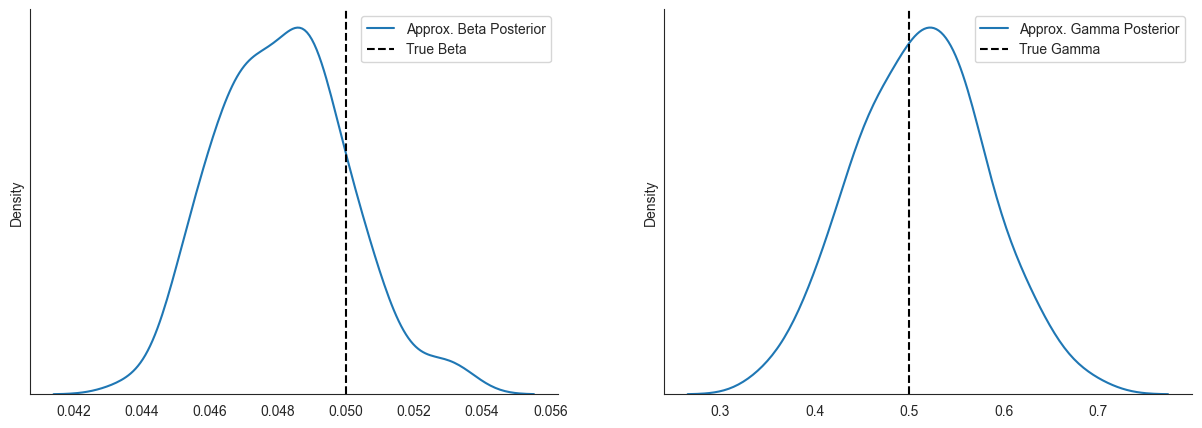

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(sir_posterior_samples["beta"], label="Approx. Beta Posterior", ax=ax[0])
ax[0].axvline(beta_true, color="black", label="True Beta", linestyle="--")
sns.despine()
ax[0].set_yticks([])
ax[0].legend(loc="upper right")

sns.kdeplot(sir_posterior_samples["gamma"], label="Approx. Gamma Posterior", ax=ax[1])
plt.axvline(gamma_true, color="black", label="True Gamma", linestyle="--")
sns.despine()
ax[1].set_yticks([])
ax[1].legend(loc="upper right")

### Next, we compare the predictive performance on the held out period between $t=1$ and $t=3$ years

In [14]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label="Posterior Mean",
        ax=ax,
    )
    # 90% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.05, dim=0),
        torch.quantile(state_pred, 0.95, dim=0),
        alpha=0.2,
        color=color,
    )

    ax.set_xlabel("Time (Yrs)")
    ax.set_ylabel(ylabel)


def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIR_test_plot(test_time, ax):
    ax.axvline(
        test_time, color="black", linestyle="dotted", label="Start of Testing Period"
    )


def SIR_plot(
    time_period,
    test_time,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax)
    SIR_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIR_test_plot(test_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

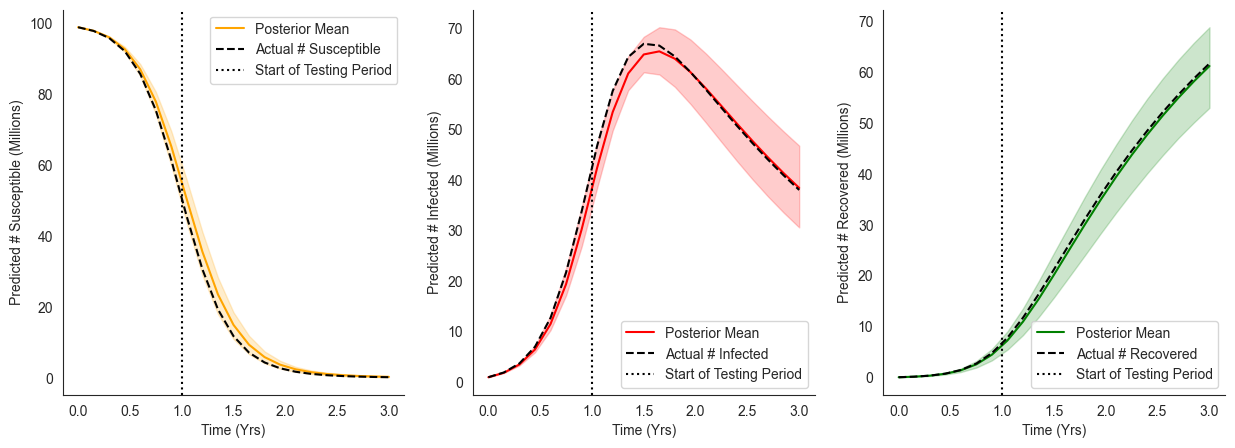

In [15]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    time_period,
    1,
    sir_posterior_samples["S"],
    sir_true_traj.S,
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
)
SIR_plot(
    time_period,
    1,
    sir_posterior_samples["I"],
    sir_true_traj.I,
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
)
SIR_plot(
    time_period,
    1,
    sir_posterior_samples["R"],
    sir_true_traj.R,
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
)

## Let's explore how different interventions might flatten the infection curve

Suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. Following [2], we define the stength of lockdown measure at time $t$ by $l_t \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

\begin{equation*}
    \beta_t = (1 - l_t) \beta_0,
\end{equation*}

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l_t$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

\begin{equation*}
    \begin{split}
        dS_t &= -\beta_t S_t I_t \\
        dI_t &= \beta_t S_t I_t - \gamma I_t \\
        dR_t &= \gamma I_t
    \end{split}
\end{equation*}

where $S_t, I_t, R_t$ denote the number of susceptable, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$.

### We can implement this new model compositionally using our existing SIR model implementation.

In [16]:
class SimpleSIRDynamicsLockdown(SimpleSIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(torch.zeros_like(gamma), gamma)
        self.beta0 = beta0

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        self.beta = (1 - X.l) * self.beta0  # time-varing beta parametrized by lockdown strength l_t
        dX.l = torch.tensor(0.0)
        # Call the base SIR class diff method
        super().diff(dX, X)


init_state_lockdown = State(
    S=torch.tensor(99.0), 
    I=torch.tensor(1.0), 
    R=torch.tensor(0.0), 
    l=torch.tensor(0.0)
)

### Let's first look at a deterministic intervention where the transmission rate is reduced by 75% between $t=1$ and $t=2$ due to stronger lockdown measures. We see in the figure below that this lockdown measures indeed "flattens" the curve.

In [17]:
def intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, tspan) -> Trajectory:
    sir = bayesian_sir(SimpleSIRDynamicsLockdown)
    with SimulatorEventLoop():
        with PointIntervention(time=torch.as_tensor(lockdown_start), intervention=State(l=torch.as_tensor(lockdown_strength))):
            with PointIntervention(time=torch.as_tensor(lockdown_end), intervention=State(l=torch.tensor(0.0))):
                solution = simulate(sir, init_state, tspan)
                # This is a small trick to make the solution variables available to pyro
                [pyro.deterministic(k, getattr(solution, k)) for k in solution.keys]
                return solution

In [18]:
lockdown_start = 1.01
lockdown_end = 2.0
lockdown_strength = 0.75

true_intervened_sir = pyro.condition(intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_intervened_trajectory = true_intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, time_period)

intervened_sir_predictive = Predictive(intervened_sir, guide=sir_guide, num_samples=100)
intervened_sir_posterior_samples = intervened_sir_predictive(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, time_period)

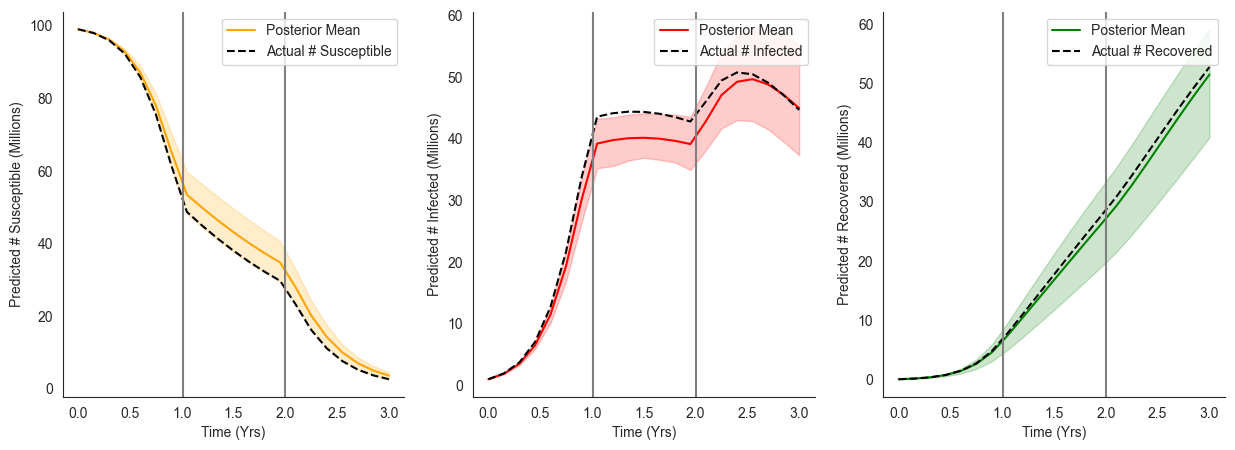

In [19]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    time_period,
    1,
    intervened_sir_posterior_samples["S"],
    true_intervened_trajectory.S,
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    intervened_sir_posterior_samples["I"],
    true_intervened_trajectory.I,
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    intervened_sir_posterior_samples["R"],
    true_intervened_trajectory.R,
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="Start of Lockdown")

## What if we're uncertain about when the lockdown will happen?

In [20]:
def uncertain_intervened_sir(lockdown_strength, init_state, tspan) -> Trajectory:
    lockdown_start = pyro.sample("lockdown_start", dist.Uniform(0.5, 1.5))
    lockdown_end = pyro.sample("lockdown_end", dist.Uniform(1.5, 2.5))
    return intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, tspan)

In [21]:
uncertain_intervened_sir_predictive = Predictive(uncertain_intervened_sir, guide=sir_guide, num_samples=100)
uncertain_intervened_sir_posterior_samples = uncertain_intervened_sir_predictive(lockdown_strength, init_state_lockdown, time_period)

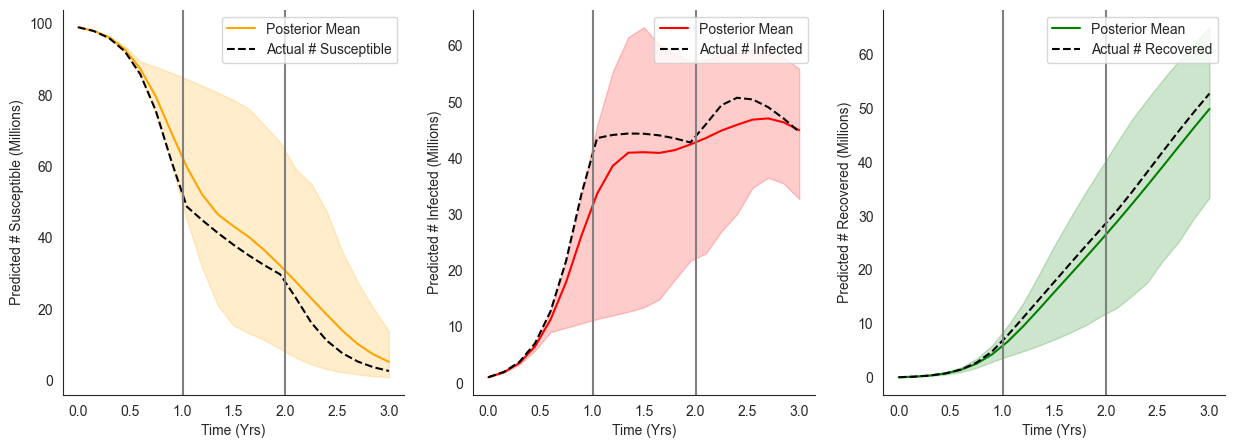

In [22]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    time_period,
    1,
    uncertain_intervened_sir_posterior_samples["S"],
    true_intervened_trajectory.S,
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    uncertain_intervened_sir_posterior_samples["I"],
    true_intervened_trajectory.I,
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    uncertain_intervened_sir_posterior_samples["R"],
    true_intervened_trajectory.R,
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="Start of Lockdown")

## Next, let's consider a state-dependent intervention ("dynamic intervention")

### Here we assume that the government will issue a lockdown measure that reduces the transmission rate by 90% whenever the number of infected people hits 30 million infected. The government removes this lockdown when 20% of the population is recovered.

In [23]:
def government_lockdown_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return state.I - target_state.I

    return event_f


def government_lift_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return target_state.R - state.R

    return event_f


def dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, tspan) -> Trajectory:
    sir = bayesian_sir(SimpleSIRDynamicsLockdown)
    with SimulatorEventLoop():
        with DynamicIntervention(event_f=government_lockdown_policy(lockdown_trigger), intervention=State(l=torch.as_tensor(lockdown_strength)), var_order=init_state.var_order, max_applications=1,):
            with DynamicIntervention(event_f=government_lift_policy(lockdown_lift_trigger), intervention=State(l=torch.tensor(0.0)), var_order=init_state.var_order, max_applications=1):
                solution = simulate(sir, init_state, tspan)
                # This is a small trick to make the solution variables available to pyro
                [pyro.deterministic(k, getattr(solution, k)) for k in solution.keys]
                return solution

In [24]:
lockdown_trigger = State(I=torch.tensor(30.0))
lockdown_lift_trigger = State(R=torch.tensor(20.0))
lockdown_strength = 0.9  # reduces transmission rate by 90%

true_dynamic_intervened_sir = pyro.condition(dynamic_intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_dynamic_intervened_trajectory = true_dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, time_period)

dynamic_intervened_sir_predictive = Predictive(dynamic_intervened_sir, guide=sir_guide, num_samples=100)
dynamic_intervened_sir_posterior_samples = dynamic_intervened_sir_predictive(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, time_period)

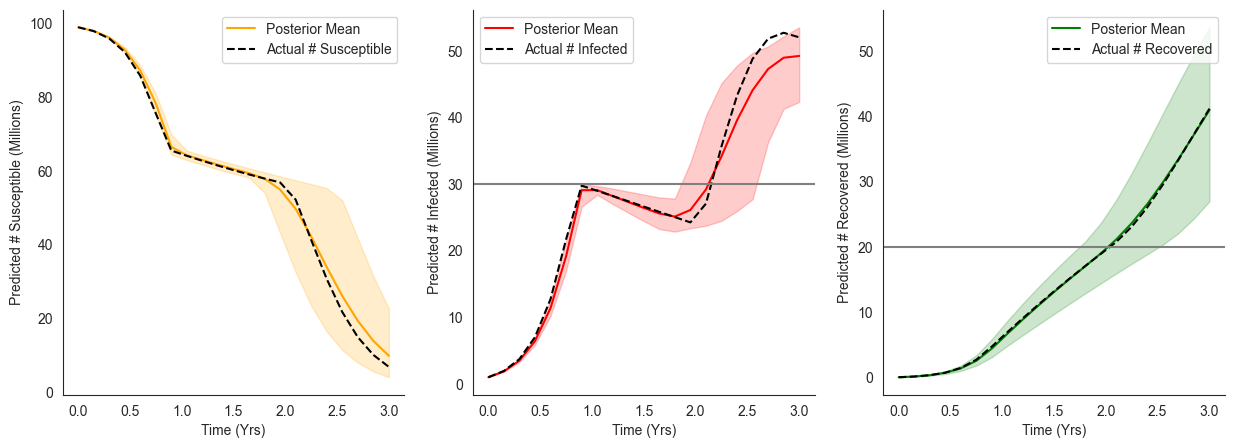

In [25]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    time_period,
    1,
    dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory.S,
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory.I,
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory.R,
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger.I, color="grey", linestyle="-")
ax[2].axhline(lockdown_lift_trigger.R, color="grey", linestyle="-")

## Again, we can represent uncertainty about the interventions themselves.

In [26]:
def uncertain_dynamic_intervened_sir(lockdown_strength, init_state, tspan) -> Trajectory:
    lockdown_trigger = State(I=pyro.sample("lockdown_trigger", dist.Uniform(30.0, 40.0)))
    lockdown_lift_trigger = State(R=pyro.sample("lockdown_lift_trigger", dist.Uniform(20.0, 30.0)))
    return dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, tspan)

In [27]:
uncertain_dynamic_intervened_sir_predictive = Predictive(uncertain_dynamic_intervened_sir, guide=sir_guide, num_samples=100)
uncertain_dynamic_intervened_sir_posterior_samples = (uncertain_dynamic_intervened_sir_predictive(lockdown_strength, init_state_lockdown, time_period))

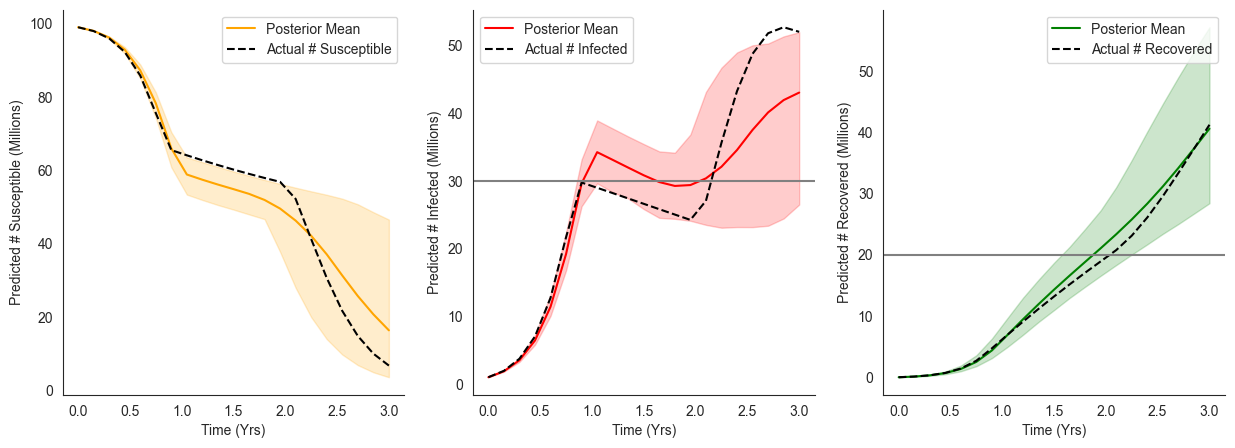

In [28]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    time_period,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory.S,
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory.I,
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    time_period,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory.R,
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger.I, color="grey", linestyle="-")
ax[2].axhline(lockdown_lift_trigger.R, color="grey", linestyle="-")

# Multilevel SIR Model

So far we have assumed we only observe data from one region. Now let's imagine we observe data from $M$ different regions, where region $m$ has transmission rate ($\beta_m$) and recovery rate ($\gamma_m$) for $1 \leq m \leq M$.


Note: we assume there are no interactions between regions (i.e., individuals from one region cannot infect those from another)

In [29]:
def unit_level_sir(unit_name, 
                   beta0_prior=dist.Uniform(0.0, 1.0), 
                   gamma_prior=dist.Uniform(0.0, 1.0)
                   ):
    beta0 = pyro.sample(f"beta0_{unit_name}", beta0_prior)
    gamma = pyro.sample(f"gamma_{unit_name}", gamma_prior)
    sir = SimpleSIRDynamics(beta0, gamma, unit_name)
    return sir


def multi_level_sir(
    N_stratum,
    init_states,
    tspan,
    beta_prior=dist.Uniform(0.0, 1.0),
    gamma_prior=dist.Uniform(0.0, 1.0),
):
    solutions = []
    for unit_ix in range(N_stratum):
        sir = unit_level_sir(unit_ix, beta_prior, gamma_prior)
        init_state = init_states[unit_ix]
        with SimulatorEventLoop():
            solution = simulate(sir, init_state, tspan)
        solutions.append(solution)
        # This is a small trick to make the solution variables available to pyro
        [pyro.deterministic(f"{k}_{unit_ix}", getattr(solution, k))for k in solution.keys]
    return solutions


def conditioned_multi_level_sir(
    multi_data,
    init_states,
    tspan,
    beta_prior=dist.Uniform(0.0, 1.0),
    gamma_prior=dist.Uniform(0.0, 1.0),
):
    for unit_ix, data in multi_data.items():
        sir = unit_level_sir(unit_ix, beta_prior, gamma_prior)
        init_state = init_states[unit_ix]
        with SimulatorEventLoop():
            if data is None:
                simulate(sir, init_state, tspan)
            else:
                with TrajectoryObservation(data):
                    simulate(sir, init_state, tspan)

In [30]:
# Generate synthetic data from the true model
obs_time_period = torch.arange(1 / 52, 1.01, 1 / 52)  # collect data
N_obs = obs_time_period.shape[0]

N_stratum = 5

multi_data = {}
init_states = []
init_state = State(
    S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0), l=torch.tensor(0.0)
)

beta0_grid = torch.tensor([0.1, 0.05, 0.075, 0.15, 0.12])
gamma_grid = torch.tensor([0.2, 0.3, 0.5, 0.35, 0.4])

sir_true_trajs = []
for unit_ix in range(N_stratum):
    beta0 = beta0_grid[unit_ix]
    gamma = gamma_grid[unit_ix]
    sir = SimpleSIRDynamics(beta0, gamma, unit_ix)
    sir_traj = simulate(sir, init_state, obs_time_period)
    sir_true_trajs.append(simulate(sir, init_state, time_period))

    data = dict()
    if unit_ix != 0:
        for time_ix in range(N_obs):
            data[obs_time_period[time_ix].item()] = sir.observation(sir_traj[time_ix])
    else:
        data = None
    multi_data[unit_ix] = data
    init_states.append(init_state)

## Unpooled Multi-level Model
First, we assume that the way each region's population responds to the infectious disease is entirely independent of every other region. This means both that individuals don't interact across regions, and also that we can't learn anything about one population by observing another. Later we'll relax this assumption to make better use of multi-region data.

In [31]:
multi_guide = run_svi_inference(conditioned_multi_level_sir, multi_data=multi_data, init_states=init_states, tspan=torch.tensor([0.0, 3.0]))

[iteration 0001] loss: 8898.9934
[iteration 0005] loss: 8743.0821
[iteration 0010] loss: 8218.0661
[iteration 0015] loss: 7987.7920
[iteration 0020] loss: 7574.0483
[iteration 0025] loss: 7265.5162
[iteration 0030] loss: 6437.3464
[iteration 0035] loss: 6190.9911
[iteration 0040] loss: 6188.3866
[iteration 0045] loss: 5639.9297
[iteration 0050] loss: 4249.2618
[iteration 0055] loss: 3399.8810
[iteration 0060] loss: 2352.3469
[iteration 0065] loss: 1983.0402
[iteration 0070] loss: 1518.2408
[iteration 0075] loss: 1545.9142
[iteration 0080] loss: 1301.6700
[iteration 0085] loss: 1249.4715
[iteration 0090] loss: 1364.3651
[iteration 0095] loss: 1271.6898
[iteration 0100] loss: 1315.3454


In [32]:
# Generate samples from the posterior predictive distribution
multi_predictive = Predictive(multi_level_sir, guide=multi_guide, num_samples=50)
multi_samples = multi_predictive(N_stratum, init_states, time_period)

## Note: We do not observe any data for the first of the five regions we wish to model.

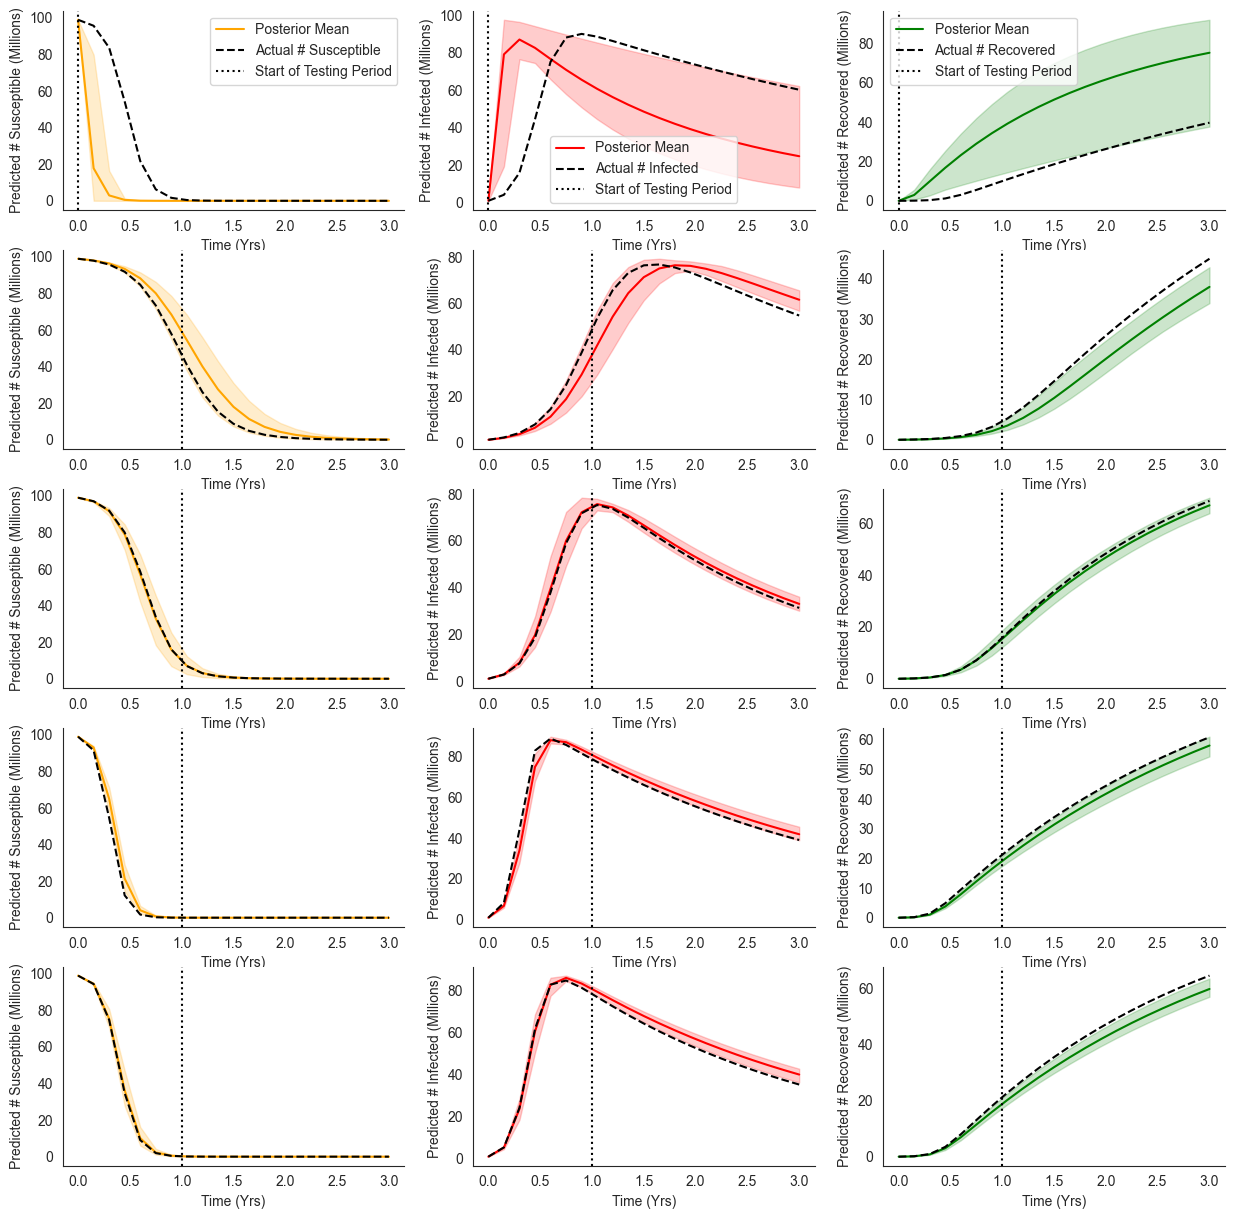

In [33]:
# Plot results
fig, ax = plt.subplots(N_stratum, 3, figsize=(15, 15))

states = ["S", "I", "R"]
colors = ["orange", "red", "green"]
pred_labels = [
    "Predicted # Susceptible (Millions)",
    "Predicted # Infected (Millions)",
    "Predicted # Recovered (Millions)",
]
data_labels = ["Actual # Susceptible", "Actual # Infected", "Actual # Recovered"]


for i in range(N_stratum):
    for j, (state, color, pred_label, data_label) in enumerate(
        zip(states, colors, pred_labels, data_labels)
    ):
        if i == 0:
            test_time = 0.0
            legend = True
        else:
            test_time = 1.0
            legend = False
        SIR_plot(
            time_period,
            test_time,
            multi_samples[f"{state}_{i}"],
            getattr(sir_true_trajs[i], state),
            pred_label,
            color,
            data_label,
            ax[i, j],
            legend=legend,
        )

## Share Information across stratum (Partial Pooling)
Here we will assume that the different regions have similar rate parameters, although we are uncertain about their values a-priori. This means that information about regions 2-5 will inform our predictions for region 1, which we do not have any observations for.


In [34]:
def beta_reparam(mean, var):
    # Formula relating mean and variance of beta distribution to alpha and beta parameters:
    # https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance
    alpha = ((1 - mean) / var - (1 / mean)) * mean**2
    beta = alpha * (1 / mean - 1)
    return alpha, beta

In [35]:
def pooling_prior():
    # We assume that there is a shared center of mass for the beta and gamma distributions
    # and that the strata-specific distributions are drawn from this center of mass.

    beta0_mean = pyro.sample("beta0_mean", dist.Uniform(0.0, 1.0))
    beta0_var = 0.05**2 # we don't think infection rate varies by more than 5% between strata

    gamma_mean = pyro.sample("gamma_mean", dist.Uniform(0.0, 1.0))
    gamma_var = 0.3**2 # we don't think recovery rate varies by more than 30% between strata

    beta0_prior = dist.Beta(*beta_reparam(beta0_mean, beta0_var))
    gamma_prior = dist.Beta(*beta_reparam(gamma_mean, gamma_var))
    return beta0_prior, gamma_prior


def pooled_multi_level_sir(N_stratum, init_states, tspan):
    # Draw priors for beta0 and gamma
    beta0_prior, gamma_prior = pooling_prior()

    # Run the multi-level SIR model with the pooled priors
    return multi_level_sir(N_stratum, init_states, tspan, beta0_prior, gamma_prior)


def pooled_conditioned_multi_level_sir(multi_data, init_states, tspan):
    # Draw priors for beta0 and gamma
    beta0_prior, gamma_prior = pooling_prior()

    # Run the multi-level SIR model with the pooled priors
    return conditioned_multi_level_sir(multi_data, init_states, tspan, beta0_prior, gamma_prior)

In [36]:
pooled_multi_guide = run_svi_inference(pooled_conditioned_multi_level_sir, multi_data=multi_data, init_states=init_states, tspan=torch.tensor([0.0, 3.0]))

[iteration 0001] loss: 9181.7137
[iteration 0005] loss: 9078.7428
[iteration 0010] loss: 8930.1430
[iteration 0015] loss: 8407.9594
[iteration 0020] loss: 7874.2850
[iteration 0025] loss: 7783.3676
[iteration 0030] loss: 7285.3548
[iteration 0035] loss: 6768.9903
[iteration 0040] loss: 5445.3096
[iteration 0045] loss: 4839.9259
[iteration 0050] loss: 3795.4104
[iteration 0055] loss: 4108.6263
[iteration 0060] loss: 2574.8624
[iteration 0065] loss: 2227.8272
[iteration 0070] loss: 1657.5953
[iteration 0075] loss: 1526.6122
[iteration 0080] loss: 1522.9320
[iteration 0085] loss: 1329.6238
[iteration 0090] loss: 1256.5673
[iteration 0095] loss: 2316.8516
[iteration 0100] loss: 1516.7996


In [37]:
# Generate samples from the posterior predictive distribution
pooled_predictive = Predictive(pooled_multi_level_sir, guide=pooled_multi_guide, num_samples=50)
pooled_samples = pooled_predictive(N_stratum, init_states, time_period)

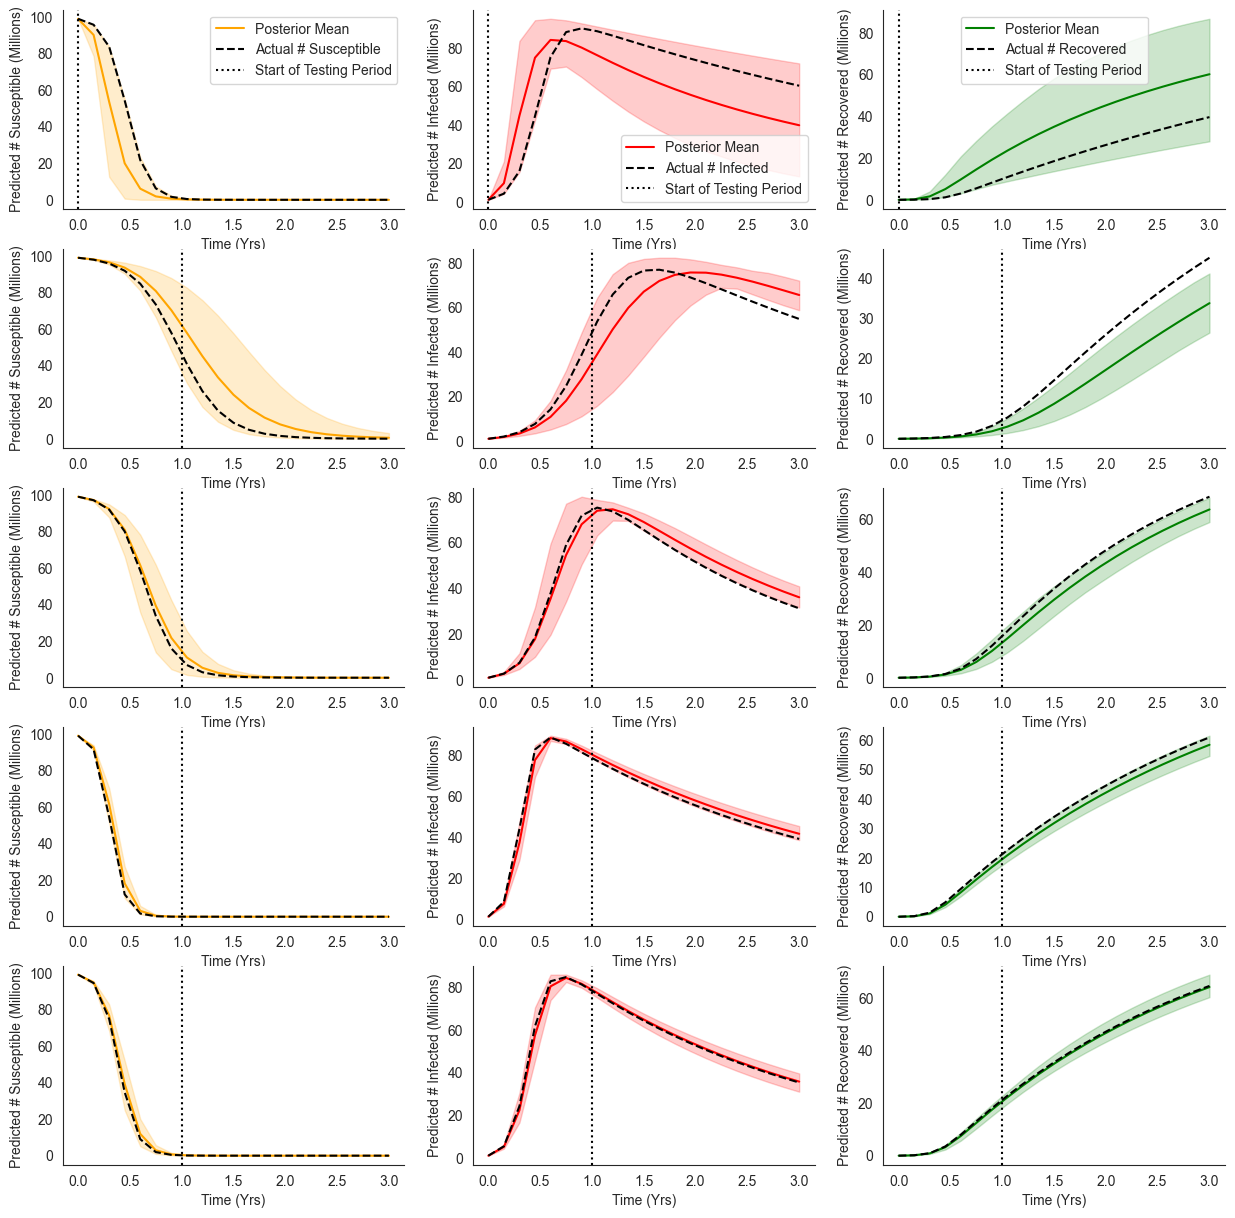

In [38]:
# Plot predicted values for S, I, and R with uncertainty bands (+/- 2 std. devs.)

fig, ax = plt.subplots(N_stratum, 3, figsize=(15, 15))

states = ["S", "I", "R"]
colors = ["orange", "red", "green"]
pred_labels = [
    "Predicted # Susceptible (Millions)",
    "Predicted # Infected (Millions)",
    "Predicted # Recovered (Millions)",
]
data_labels = ["Actual # Susceptible", "Actual # Infected", "Actual # Recovered"]


for i in range(N_stratum):
    for j, (state, color, pred_label, data_label) in enumerate(
        zip(states, colors, pred_labels, data_labels)
    ):
        if i == 0:
            test_time = 0.0
            legend = True
        else:
            test_time = 1.0
            legend = False
        SIR_plot(
            time_period,
            test_time,
            pooled_samples[f"{state}_{i}"],
            getattr(sir_true_trajs[i], state),
            pred_label,
            color,
            data_label,
            ax[i, j],
            legend=legend,
        )

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan
2. https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf